<a href="https://colab.research.google.com/github/KunalVaidya99/HappyMonk-Internship-Test/blob/main/HappyMonk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Kunal Vaidya
kunavaidya@gmail.com

Importing Necessary Libraries

In [1]:
import numpy as np
import pandas  as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pprint
from numpy_ml.neural_nets.losses import CrossEntropy
from sklearn.metrics import confusion_matrix, f1_score

Loading the Dataset


In [3]:
banknote = pd.read_csv("/content/BankNote_Authentication.csv")
banknote.head()
x, y = banknote.iloc[:,0:4], banknote.iloc[:,4]

encoder = OneHotEncoder(sparse = False)  #One hot Encoding labels
scaler = StandardScaler()
x = scaler.fit_transform(x)  # Scaling the data
y = encoder.fit_transform(np.array(y).reshape(-1,1))


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y)  #80-20 spilt of dataset into training and test

In [27]:
l = x_train.shape[1]
n = 2 #neurons in hidden layer 1
p = 2 #neurons in hidden layer 2
layer_dims = [l, n, p, 2]   #list containing neurons in each layer

def initialize_parameters(layer_dims):

  np.random.seed(1)

  parameters = dict()

  length = len(layer_dims)

  for i in range(1, length):
    parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1])*0.01  #sampling parameters form standard normal distribution
    parameters["b" + str(i)] = np.random.randn(layer_dims[i],1)

  k0 = np.random.randn(1)
  k1 = np.random.randn(1)   #sampling parameters form standard normal distribution
  k2 = np.random.randn(1)

  K = [k0.item(), k1.item(), k2.item()]
  parameters["K"] = K

 
  return parameters                

Softmax Activation Function

In [6]:
def softmax(Z):

  temp = np.exp(Z)

  ax_sum = np.expand_dims(np.sum(temp, axis = 1),axis=-1)
  activated_output = temp/ax_sum
  return activated_output

Forward Propagation

In [37]:
def forward_propagation(parameters, batch):

  A = batch.T

  activations = dict()
  layer_outputs = dict()

  activations["A" + str(0)] = batch

  for i in range(1, len(layer_dims)):
    #print(i)

    
    Z = np.dot(parameters["W"+str(i)], A) + parameters["b" + str(i)]   #Forward Prop equation of a neural network 
    
    
    if (i < len(layer_dims)-1):
      A = parameters["K"][0] + parameters["K"][1]*Z + parameters["K"][2]*(np.multiply(Z,Z))
    else:                                                                                    #Last layer activation is softmax
      A = softmax(Z)
    activations["A" + str(i)] = A                    # Storing activations and Z's of each layer inside a dictionary to access later for backpropagation
    layer_outputs["Z"+ str(i)] = Z 


  return activations, layer_outputs

In [8]:
def cross_entropy(predictions, actual):
  N = predictions.shape[1]
  
  loss = -np.sum(np.log(predictions)*actual.T)/N
  return loss

In [9]:
def compute_cost(predictions, actual):
  
  loss = cross_entropy(predictions, actual)
  return loss

Back Propagation

In [10]:
def backward_propagation(parameters, activations, layer_outputs, batch_size, Y):

  gradients = dict()   # Dictionary for storing gradients of each layer and parameter
  gradients["dK"] = 0
  

  for i in reversed(range(1, len(layer_dims))):
    

   #################### Backpropgation Equations################################### 
    if (i==len(layer_dims)-1):
      
      gradients["dZ" + str(i)] =  activations["A" + str(i)] - Y.T
      
      
      gradients["dW" + str(i)] = np.dot(gradients["dZ" + str(i)], activations["A" + str(i-1)].T)/batch_size
    
      gradients["db" + str(i)] = np.mean(gradients["dZ" + str(i)], axis=1, keepdims=True)
   
    activations["A0"] = activations["A0"].T  
    if (0 <i < len(layer_dims)-1 ):
      
    
      gradients["dA" + str(i)] = np.dot( parameters["W" + str(i+1)].T, gradients["dZ" + str(i+1)])

      gradients["dZ" + str(i)] = (parameters["K"][1] + 2*parameters["K"][2]*layer_outputs["Z" + str(i)])* activations["A" + str(i)]
  
      
      gradients["dW" + str(i)] = np.dot(gradients["dZ" + str(i)], activations["A" + str(i-1)].T)/batch_size

      gradients["db" + str(i)] = np.mean(gradients["dZ" + str(i)], axis=1, keepdims=True)

      gradients["dK" + str(i)] = np.array([np.mean(gradients["dA" +  str(i)]), 
                                           np.mean(np.multiply(gradients["dA" +  str(i)],layer_outputs["Z"+str(i)])), 
                                           np.mean(np.multiply(gradients["dA" + str(i)], layer_outputs["Z"+str(i)]*layer_outputs["Z"+str(i)]))])
      
  for j in range(1, len(layer_dims)-1):
    
    gradients["dK"] = gradients["dK"] + gradients["dK" + str(j)]     

  return gradients


Parameter Update

In [11]:
def update_parameters(parameters, gradients, learning_rate):

  for i in range(1, len(layer_dims)):
    parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate * gradients["dW" + str(i)]    # Update parameters using gradients, W = W - alpha*dW  
    parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate * gradients["db" + str(i)] 

  parameters["K"] = parameters["K"] - 10*learning_rate * gradients["dK"]

  return parameters 

Function to generate random mini batches

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 9):
    
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    
   
    permutation = list(np.random.permutation(m))

    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation]

   
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Function to calculate accuracy and loss at end of epoch

In [34]:
def predict(x, y, parameters):
    
    
    activations, layer_outputs = forward_propagation(parameters, x)
     
    # convert probas to 0/1 predictions 
    for i in range(0, x.shape[0]):
        label = np.argmax(activations["A" + str(len(layer_dims)-1)], axis=0)    # convert softmax output to single label
        true_label = np.argmax(y, axis=1)
    
    test_cost = compute_cost(activations["A" + str(len(layer_dims)-1)], y)

    accuracy = np.sum((label == true_label)/x.shape[0])   #computing accuracy
   # print("Accuracy: "  + str(np.sum((label == true_label)/x_train.shape[0])))
    return accuracy, test_cost

In [35]:
costs = []
store_params = []
test_costs = []
test_accuracies = []
train_accuracies = []
def train(epochs, batch_size, learning_rate):

  parameters = initialize_parameters(layer_dims)     #initialize parameters 
  pp = pprint.PrettyPrinter()
  pp.pprint(parameters)
  
  for epoch in range(epochs):
    print("EPoch is", epoch)
    cost_epoch = 0   
    mini_batches = random_mini_batches(np.array(x_train), np.array(y_train))    #generate mini batches at start of each epoch

    for mini_batch in mini_batches:
    
      activations, layer_outputs = forward_propagation(parameters, mini_batch[0])     #forward propagation

      cost = compute_cost(activations["A" + str(len(layer_dims)-1)], mini_batch[1])
      #cost = CrossEntropy.loss(mini_batch[1].T, activations["A3"])
      gradients = backward_propagation(parameters, activations, layer_outputs, batch_size, mini_batch[1])  #calculating gradients for each parameter
      
      parameters = update_parameters(parameters, gradients, learning_rate)   #updating parameters using gradients
      #print(parameters)
      
      cost_epoch = cost_epoch + cost/batch_size
    
    

    train_accuracy, train_cost = predict(x_train, y_train, parameters)
    test_accuracy, test_cost = predict(x_test, y_test, parameters)
    test_costs.append(test_cost)
    costs.append(train_cost)
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)
    #print(gradients)
    print("Train Cost:", train_cost)
    print("Test Cost:", test_cost)
    print("Train Accuracy:", 100*train_accuracy) 
    print("Test Accuracy:", 100*test_accuracy) 

  return parameters

In [36]:
params = train(70, 64, 0.00001)   # training loop

{'K': [0.9015907205927955, 0.5024943389018682, 0.9008559492644118],
 'W1': array([[ 0.01624345, -0.00611756, -0.00528172, -0.01072969],
       [ 0.00865408, -0.02301539,  0.01744812, -0.00761207]]),
 'W2': array([[ 0.01462108, -0.02060141],
       [-0.00322417, -0.00384054]]),
 'W3': array([[-0.00172428, -0.00877858],
       [ 0.00042214,  0.00582815]]),
 'b1': array([[ 0.3190391 ],
       [-0.24937038]]),
 'b2': array([[ 1.13376944],
       [-1.09989127]]),
 'b3': array([[-1.10061918],
       [ 1.14472371]])}
EPoch is 0
Train Cost: 6.936343415621814
Test Cost: 5.837731181003425
Train Accuracy: 20.99125364431487
Test Accuracy: 18.950437317784257
EPoch is 1
Train Cost: 6.936343331557881
Test Cost: 5.837731089555204
Train Accuracy: 20.89407191448008
Test Accuracy: 18.950437317784257
EPoch is 2
Train Cost: 6.93634324993225
Test Cost: 5.837731000759531
Train Accuracy: 20.796890184645285
Test Accuracy: 18.950437317784257
EPoch is 3
Train Cost: 6.936343170706242
Test Cost: 5.837730914574289


Text(0, 0.5, 'Accuracy')

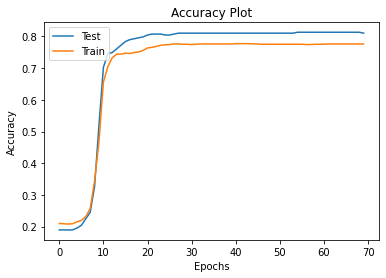

In [30]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(costs)), test_accuracies, label="Test")
plt.plot(np.arange(len(costs)), train_accuracies, label="Train")
plt.title("Accuracy Plot")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

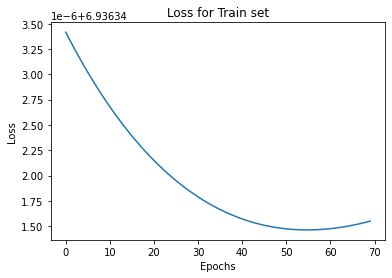

In [31]:
plt.plot(np.arange(len(costs)), costs)
plt.title("Loss for Train set")
plt.xlabel('Epochs')
plt.ylabel('Loss')

Compute confusion matrix and F1-score


In [33]:
def plot_matrix(x, y):
  a, _ = forward_propagation(params, x)
  predicted_labels = np.argmax(a["A" + str(len(layer_dims)-1)], axis=0)
  true_labels = np.argmax(y, axis=1)
  f1 = f1_score(true_labels, predicted_labels)
  print("The f1 score is:", f1)

  cf_matrix = confusion_matrix(true_labels, predicted_labels)
  import seaborn as sns
  sns.heatmap(cf_matrix, annot=True, fmt ='d')



The f1 score is: 0.7653061224489796


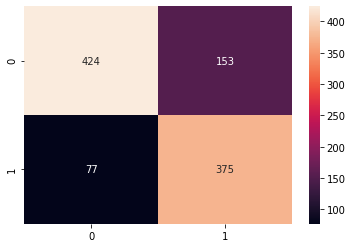

In [21]:
plot_matrix(x_train, y_train)